## Airbnb SD 房价分析

In [103]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

#machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

In [142]:
filepath = '/Users/ziyangwang/Desktop/415FinalProject/AB_SD_2019.csv' 
df = pd.read_csv(filepath)
df.shape

(13236, 16)

In [143]:
df = df[(df['neighbourhood']=='Mission Bay') 
         |(df['neighbourhood'] =='Pacific Beach') 
         | (df['neighbourhood'] == 'North Park')
         | (df['neighbourhood'] == 'La Jolla')
         | (df['neighbourhood'] =='East Village')
        |(df['neighbourhood'] =='Ocean Beach')
        |(df['neighbourhood'] == 'Midtown')
        |(df['neighbourhood'] =='Ocean Beach')
        |(df['neighbourhood'] =='Balboa Park')
        |(df['neighbourhood'] =='Loma Portal')
        |(df['neighbourhood'] =='University City')
        |(df['neighbourhood'] =='Gaslamp Quarter')
        |(df['neighbourhood'] == 'Park West')                     
        |(df['neighbourhood'] == 'Little Italy')                   
        |(df['neighbourhood'] =='West University Heights')
        |(df['neighbourhood'] =='Bay Park')                   
        |(df['neighbourhood'] =='Grant Hill')]

In [151]:
df.shape

(7962, 13)

## 替换错误信息

In [146]:
df.neighbourhood.replace('North Hills', 'North Park', inplace=True)

房间名称、房主名的缺失相对较少，考虑房间和房东的名字对数据建模的贡献不大，所以将这两列删除掉。

In [147]:
df.drop(['host_name','name','neighbourhood_group'], axis=1, inplace=True)

每月评论数量、最新评论时间的缺失值相对较多，占到整个样本数量的20%，删除缺失值所在的样本会损失很多数据。

且从理论上来讲，评论数量的多少可能和房价之间存在着不可描述的关系，所以删除特征列也不妥。那就只能填补缺失值了。

再进一步分析，如果某些房间没有评论，那么自然最新评论时间和每月评论数量都会为0。所以我们不妨看一下，这个缺失是不是由于0评论导致的

In [148]:
df[df['reviews_per_month']==0.0].shape

(0, 13)

找到最早的评论时间

In [149]:
df['last_review'] = pd.to_datetime(df['last_review'], format='%Y/%m/%d')
print(df['last_review'].min())

2012-08-14 00:00:00


用0填补reviews_per_month 并用整个数据集最早的评论时间填补last_review.

In [152]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
earliest = (df['last_review'].min())
df['last_review'] = df['last_review'].fillna(earliest)

为了方便分析建模，将last_review转为数值型

In [153]:
df['last_review'] = df['last_review'].apply(lambda x:x.toordinal() - earliest.toordinal())

In [154]:
total = df.isnull().sum().sort_values(ascending=False) 
percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Percent']).sort_values('Total', ascending=False)
missing_data

,Total,Percent
availability_365,0,0.0
calculated_host_listings_count,0,0.0
reviews_per_month,0,0.0
last_review,0,0.0
number_of_reviews,0,0.0
minimum_nights,0,0.0
price,0,0.0
room_type,0,0.0
longitude,0,0.0
latitude,0,0.0


In [155]:
df.head(6)

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,5570,8435,Mission Bay,32.78430,-117.25258,Entire home/apt,2050,3,0,0,0.00,2,202
4,52286,215810,Mission Bay,32.77784,-117.25355,Entire home/apt,550,7,0,0,0.00,1,89
5,54001,252692,La Jolla,32.81190,-117.26952,Private room,110,2,203,2575,1.91,5,329
6,62274,302986,Pacific Beach,32.80734,-117.24243,Entire home/apt,68,2,525,2579,4.90,2,242
7,62949,21532,Pacific Beach,32.80961,-117.23056,Entire home/apt,75,1,596,2592,6.91,2,128
9,69385,347408,Mission Bay,32.78646,-117.25434,Entire home/apt,479,3,184,2594,1.76,1,327


# 建模数据的准备

## 哑变量的处理

使用pandas的get_dummies模块可以快速对所有的分类变量哑变量化。

In [156]:
object_features = df.select_dtypes(include=['object'])
object_features.columns

Index(['neighbourhood', 'room_type'], dtype='object')

非数值化的特征主要有：neighbourhood，room_type。

In [157]:
object_features_oh=pd.get_dummies(object_features)
object_features_oh.head()

,neighbourhood_Balboa Park,neighbourhood_Bay Park,neighbourhood_East Village,neighbourhood_Gaslamp Quarter,neighbourhood_Grant Hill,neighbourhood_La Jolla,neighbourhood_Little Italy,neighbourhood_Loma Portal,neighbourhood_Midtown,neighbourhood_Mission Bay,neighbourhood_Ocean Beach,neighbourhood_Pacific Beach,neighbourhood_Park West,neighbourhood_University City,neighbourhood_West University Heights,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## 数据集准备

In [158]:
#首先提取出所有的数值型数据
num_features = df.select_dtypes(exclude=['object'])
#将房价单独提出
y = num_features.loc[:,'price']
num_features.drop(columns=['price'],axis=1,inplace=True)
#拼接成新的数据集
new_data = pd.concat([num_features,object_features_oh,y],axis=1)
#获取columns列表
new_data.columns.tolist()
new_data.shape

/Users/ziyangwang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(7962, 30)

## 存储new_data

In [159]:
new_data.to_csv('/Users/ziyangwang/Desktop/415FinalProject/Processed_AB_NYC2019.csv')

## 数值的标准化 

In [169]:
from sklearn.preprocessing import scale,RobustScaler
y = new_data.iloc[:,-1]
X = new_data.iloc[:,:-1]
columns=X.columns.tolist()
scaler=RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=columns)
X.head()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_Mission Bay,neighbourhood_Ocean Beach,neighbourhood_Pacific Beach,neighbourhood_Park West,neighbourhood_University City,neighbourhood_West University Heights,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,-1.234195,-0.432766,0.327607,-0.216353,0.5,-0.268293,-6.350746,-0.330677,-0.076923,0.169118,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.231511,-0.430718,0.236464,-0.226875,2.5,-0.268293,-6.350746,-0.330677,-0.153846,-0.246324,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.231412,-0.430353,0.717012,-0.400108,0.0,4.682927,0.054726,0.430279,0.153846,0.636029,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0
3,-1.230937,-0.429856,0.652675,-0.106251,0.0,12.536585,0.064677,1.621514,-0.076923,0.316176,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.230898,-0.432637,0.684702,0.022508,-0.5,14.268293,0.097015,2.422311,-0.076923,-0.102941,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 房价评估模型

In [161]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=42)
print(f'The shape of Xtrain:{Xtrain.shape}')
print(f'The shape of Xtest:{Xtest.shape}')
print(f'The shape of ytrain:{ytrain.shape}')
print(f'The shape of ytest:{ytest.shape}')


The shape of Xtrain:(6369, 29)
The shape of Xtest:(1593, 29)
The shape of ytrain:(6369,)
The shape of ytest:(1593,)


## 随机森林模型

In [164]:
def r2_score(model):
    return cross_val_score(model,Xtrain,ytrain,cv=8)
def rmse_score(model):
    return cross_val_score(model,Xtrain,ytrain,scoring='neg_mean_squared_error',cv=8)

In [163]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


base_rfr_cv = r2_score(RandomForestRegressor(random_state=42))
base_rfr_model=RandomForestRegressor(random_state=42)
base_rfr_model = base_rfr_model.fit(Xtrain,ytrain)
rfr_predict_ytrain = base_rfr_model.predict(Xtrain)
rfr_predict_ytest = base_rfr_model.predict(Xtest)
base_rfr_result=pd.DataFrame({'model':['RandomForestRegressor'],
                'CV_rfr_r2:':base_rfr_cv.mean(),
                'train error:':mean_squared_error(rfr_predict_ytrain,ytrain),
                'test error:':mean_squared_error(rfr_predict_ytest,ytest)})
base_rfr_result

,model,CV_rfr_r2:,train error:,test error:
0,RandomForestRegressor,0.02595,18978.145491,130277.244771


In [165]:
from sklearn.model_selection import  RandomizedSearchCV
n_estimators=[x for x in range(20,2000,20)]
max_depth=[x for x in range(1,10,1)]
max_features=['auto','sqrt']
min_samples_split=[2,4,7]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
random_grid={'n_estimators':n_estimators,
             'max_features':max_features,
             'max_depth':max_depth,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'bootstrap':bootstrap
}
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42)
rf_random.fit(Xtrain, ytrain)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total=  28.8s
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s


[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total=  30.1s
[CV] n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False 
[CV]  n_estimators=1860, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=5, bootstrap=False, total=  24.2s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True, total=   4.5s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True, total=   4.8s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=9, bootstrap=True 
[CV]  n_estimators=1100, min_samp

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 106...7, 8, 9], 'min_samples_split': [2, 4, 7], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          retur

## 查看搜索到的最佳模型

In [166]:
best_rfr=rf_random.best_estimator_
best_rfr

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [167]:
rfr_best_score=r2_score(best_rfr)
rfr_best_model=best_rfr.fit(Xtrain,ytrain)
predict_ytrain_rfr=rfr_best_model.predict(Xtrain)
precict_ytest_rfr = rfr_best_model.predict(Xtest)
rfr_result=pd.DataFrame({'algorithm:':['RandomForestRegressor'],
                        'CV_rfr_r2:':rfr_best_score.mean(),
                        'train error:':mean_squared_error(predict_ytrain_rfr,ytrain),
                        'test error:':mean_squared_error(precict_ytest_rfr,ytest)}
                       )
rfr_result

,algorithm:,CV_rfr_r2:,train error:,test error:
0,RandomForestRegressor,0.250452,73380.659789,109972.555674


## 特征选择

In [170]:
#对整体数据集进行标准化处理
columns=X.columns.tolist()
scaler=RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=columns)
X.head()
#进行特征选择
from sklearn.feature_selection import VarianceThreshold
selector=VarianceThreshold(.9*(1-.9))
X_var = selector.fit_transform(X)
#获得筛选出特征的columns
X_var_columns = X.columns[selector.get_support(indices=True)]
X_var = pd.DataFrame(X_var,columns=X_var_columns)
X_var.head()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_East Village,neighbourhood_La Jolla,neighbourhood_Mission Bay,neighbourhood_Pacific Beach,room_type_Entire home/apt,room_type_Private room
0,-1.234195,-0.432766,0.327607,-0.216353,0.5,-0.268293,-6.350746,-0.330677,-0.076923,0.169118,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.231511,-0.430718,0.236464,-0.226875,2.5,-0.268293,-6.350746,-0.330677,-0.153846,-0.246324,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.231412,-0.430353,0.717012,-0.400108,0.0,4.682927,0.054726,0.430279,0.153846,0.636029,0.0,1.0,0.0,0.0,-1.0,1.0
3,-1.230937,-0.429856,0.652675,-0.106251,0.0,12.536585,0.064677,1.621514,-0.076923,0.316176,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.230898,-0.432637,0.684702,0.022508,-0.5,14.268293,0.097015,2.422311,-0.076923,-0.102941,0.0,0.0,0.0,1.0,0.0,0.0


## 再次进行训练集和测试集划分

In [171]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=42)

## 随机森林调参

调参思想：
随机森林模型中重要的参数有 n_estimators, max_depth, max_features, min_sample_leaf， min_sample_split。
n_estimators 参数决定森林模型中树的数量，而其余参数决定每棵树的特征, 先对后几个参数进行调参，再调n_estimators 会在提高效率的同时得到相对更合理的模型。

首先对 max_depth, max_features, min_sample_leaf， min_sample_split 四个参数进行试探的交叉验证。


In [172]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [173]:
#为避免警告信息，这里现将n_estimators设定为10.
n_estimators=[10]
max_depth=[i for i in range(5,10,2)]
max_features=[i for i in range(5,14,1)]
min_samples_leaf=[i for i in range(2,10,1)]
min_samples_split=[i for i in range(2,5,1)]
parameters = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'max_features':max_features,
    'min_samples_leaf':min_samples_leaf,
    'min_samples_split':min_samples_split
}
rfr = RandomForestRegressor(random_state=42)
GS=GridSearchCV(rfr,parameters,cv=3)
GS.fit(Xtrain,ytrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10], 'max_depth': [5, 7, 9], 'max_features': [5, 6, 7, 8, 9, 10, 11, 12, 13], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## 对max_depth跑学习曲线

In [89]:
train_score_list=[]
train_error_list=[]
test_score_list=[]
test_error_list=[]
for i in range(9,29,1):
    model = RandomForestRegressor(max_depth=i,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list.append(train_error)
    test_error_list.append(test_error)


The min testSet error is 134926.22481688258 when max_depth = 9


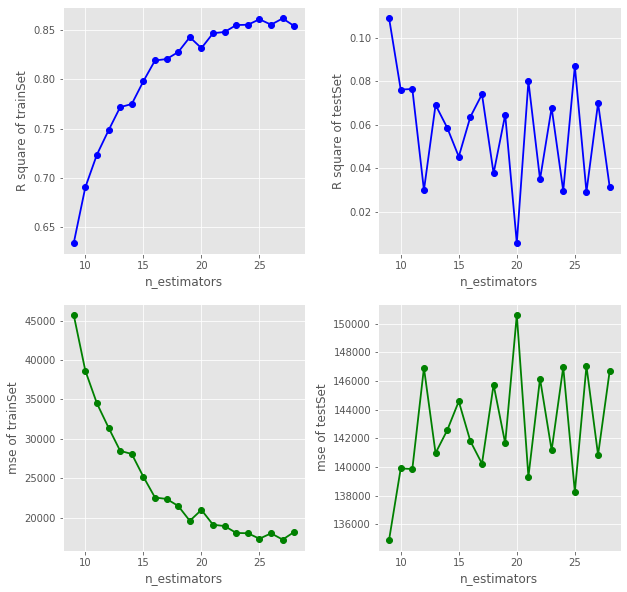

In [90]:
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(9,29,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list)} when max_depth = {x[np.argmin(test_error_list)]}")

## 对max_features跑学习曲线

In [92]:
train_score_list2=[]
train_error_list2=[]
test_score_list2=[]
test_error_list2=[]
for i in range(1,14,1):
    model = RandomForestRegressor(max_depth=10,max_features=i,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list2.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list2.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list2.append(train_error)
    test_error_list2.append(test_error)

The min testSet error is 126633.78754673702 when max_depth = 11


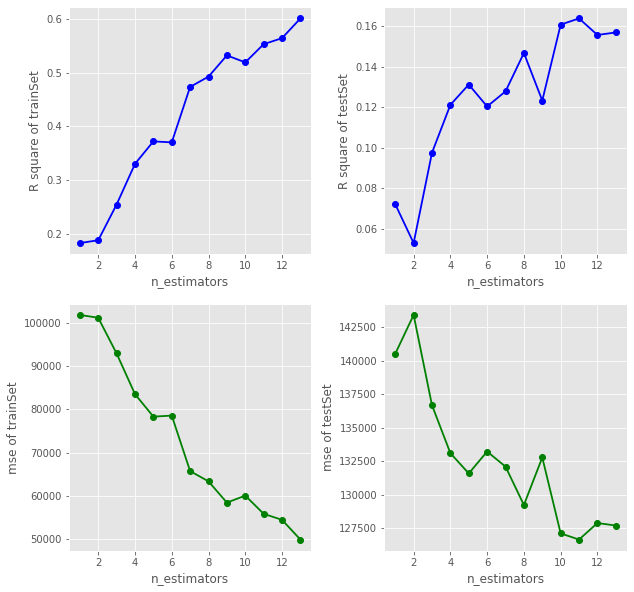

In [93]:
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(1,14,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list2,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list2,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list2,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list2,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list2)} when max_depth = {x[np.argmin(test_error_list2)]}")

## min_samples_leaf 学习曲线

The min testSet error is 131160.52319599446 when min_samples_leaf = 10


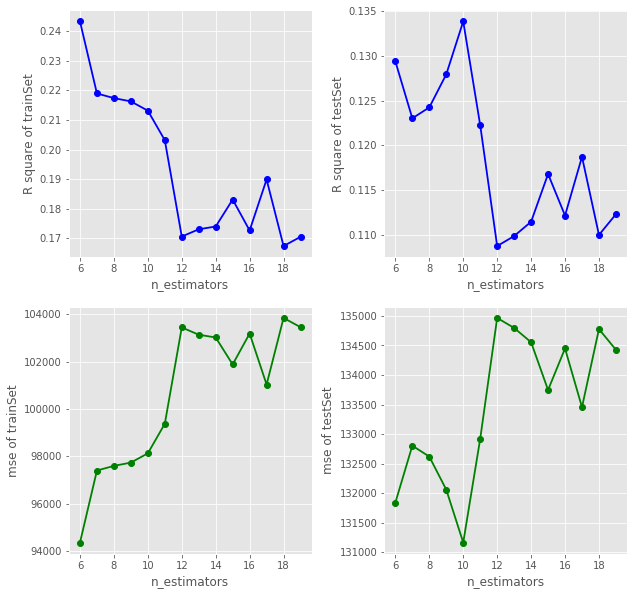

In [95]:
train_score_list3=[]
train_error_list3=[]
test_score_list3=[]
test_error_list3=[]
for i in range(6,20,1):
    model = RandomForestRegressor(max_depth=10,min_samples_leaf=i,max_features=7,random_state=42).fit(Xtrain,ytrain)
    train_score = model.score(Xtrain,ytrain)
    train_score_list3.append(train_score)
    test_score = model.score(Xtest,ytest)
    test_score_list3.append(test_score)
    predict_ytrain=model.predict(Xtrain)
    predict_ytest =model.predict(Xtest)
    train_error=mean_squared_error(predict_ytrain,ytrain)
    test_error = mean_squared_error(predict_ytest,ytest)
    train_error_list3.append(train_error)
    test_error_list3.append(test_error)

import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(6,20,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list3,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list3,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list3,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list3,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list3)} when min_samples_leaf = {x[np.argmin(test_error_list3)]}")

至此，我们将max_depht, max_features,min_samples_leaf 的最佳取值都锁定了。
检验一下此时模型的效果：

In [96]:
model = RandomForestRegressor(max_depth=10,max_features=7,min_samples_leaf=18,random_state=42).fit(Xtrain,ytrain)
print(f'train Score is {model.score(Xtrain,ytrain)}')
print(f'test Score is {model.score(Xtest,ytest)}')
print(f'train mse is {mean_squared_error(model.predict(Xtrain),ytrain)}')
print(f'train mse is {mean_squared_error(model.predict(Xtest),ytest)}')

train Score is 0.1673692144126212
test Score is 0.10996244490132245
train mse is 103838.62979531783
train mse is 134778.09772283054


## 对n_estimator进行调参 

The min testSet error is 134174.21357769772 when min_samples_leaf = 40


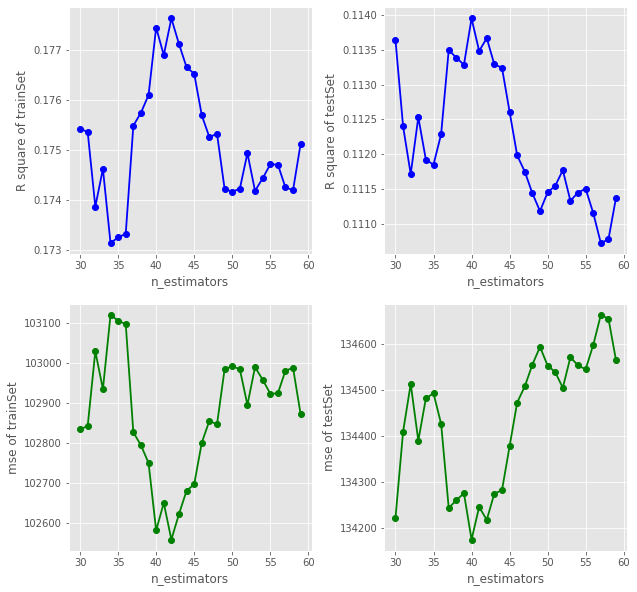

In [97]:
n_estimators=[i for i in range(30,60,1)]
train_score_list5=[]
test_score_list5=[]
train_error_list5=[]
test_error_list5=[]

for i in n_estimators:
    rfr = RandomForestRegressor(random_state=42,n_estimators=i,max_depth=10,max_features=7,min_samples_leaf=18)
    rfr = rfr.fit(Xtrain,ytrain)
    train_score_list5.append(rfr.score(Xtrain,ytrain))
    test_score_list5.append(rfr.score(Xtest,ytest))
    predict_ytrain = rfr.predict(Xtrain)
    predict_ytest = rfr.predict(Xtest)
    mse_train=mean_squared_error(predict_ytrain,ytrain)
    mse_test=mean_squared_error(predict_ytest,ytest)
    train_error_list5.append(mse_train)
    test_error_list5.append(mse_test)

#可视化
import matplotlib.style as style
style.use('ggplot')
x=[i for i in range(30,60,1)]
fig,ax=plt.subplots(2,2,figsize=(10,10))
ax[0][0].plot(x,train_score_list5,'o-',linewidth=1.8 ,color='blue')
ax[0][0].set_xlabel(xlabel='n_estimators')
ax[0][0].set_ylabel(ylabel='R square of trainSet')

ax[0][1].plot(x,test_score_list5,'o-',linewidth=1.8,color='blue')
ax[0][1].set_xlabel(xlabel='n_estimators')
ax[0][1].set_ylabel(ylabel='R square of testSet')

ax[1][0].plot(x,train_error_list5,'o-',linewidth=1.8,color='green')
ax[1][0].set_xlabel(xlabel='n_estimators')
ax[1][0].set_ylabel(ylabel='mse of trainSet')

ax[1][1].plot(x,test_error_list5,'o-',linewidth=1.8,color='green')
ax[1][1].set_xlabel(xlabel='n_estimators')
ax[1][1].set_ylabel(ylabel='mse of testSet')
plt.subplots_adjust(
#                     left=0.1
#                     , bottom=0.1
#                     ,right=0.2
#                     ,top=None
#                     ,
    wspace=0.3
                    ,hspace=0.2
                   )
print(f"The min testSet error is {min(test_error_list5)} when min_samples_leaf = {x[np.argmin(test_error_list5)]}")

## 最终模型

In [98]:
model_best = RandomForestRegressor(max_depth=10,max_features=7,min_samples_leaf=18,random_state=42,n_estimators=46).fit(Xtrain,ytrain)
print(f'train Score is {model_best.score(Xtrain,ytrain)}')
print(f'test Score is {model_best.score(Xtest,ytest)}')
print(f'train mse is {mean_squared_error(model_best.predict(Xtrain),ytrain)}')
print(f'train mse is {mean_squared_error(model_best.predict(Xtest),ytest)}')

train Score is 0.17569521623295292
test Score is 0.11198228684019507
train mse is 102800.28166351453
train mse is 134472.23371443836


## 评估

Prediction with residual less than 1:0.5%


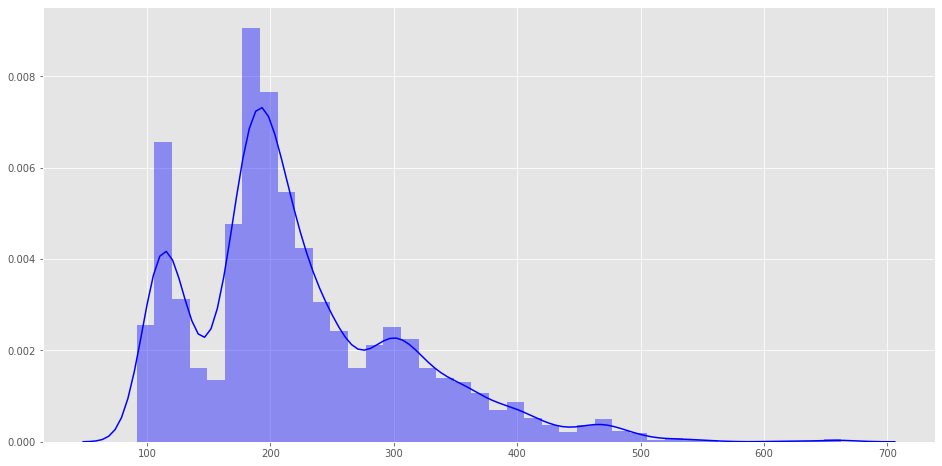

In [101]:
predict_ytest = model_best.predict(Xtest)
predict_error = np.abs(predict_ytest-ytest)
percent=("%.3f"%(predict_error[predict_error<1].shape[0]/predict_error.shape[0]))
fig,ax=plt.subplots(figsize=(16,8))
import seaborn as sns
sns.distplot(predict_ytest,ax=ax,color='blue',bins=40)
print(f"Prediction with residual less than 1:{float(percent)*100}%")

## 影响房价的主要因素：

In [102]:
importance = model_best.feature_importances_
columns = Xtrain.columns
s = pd.Series(data=importance,index=columns)
s.sort_values(ascending=False)

longitude                         0.154353
calculated_host_listings_count    0.124669
room_type_Entire home/apt         0.117460
room_type_Private room            0.089497
number_of_reviews                 0.068554
                                    ...   
neighbourhood_La Jolla Village    0.000000
neighbourhood_Lake Murray         0.000000
neighbourhood_Lincoln Park        0.000000
neighbourhood_Thomy Locust Pl     0.000000
neighbourhood_Lynwood Hills       0.000000
Length: 117, dtype: float64

In [60]:
new_data.head(6)

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,...,neighbourhood_Valencia Park,neighbourhood_Webster,neighbourhood_West University Heights,neighbourhood_Wooded Area,neighbourhood_Yosemite Dr,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price
0,6,29,32.75399,-117.12971,1,152,2019-02-11,1.11,1,6,...,0,0,0,0,0,1,0,0,0,295
1,5570,8435,32.78430,-117.25258,3,0,2012-08-14,0.00,2,202,...,0,0,0,0,0,1,0,0,0,2050
2,38245,164137,32.74202,-117.21870,1,142,2019-09-02,1.29,3,347,...,0,0,0,0,0,0,0,1,0,75
3,39516,169649,32.73188,-117.11918,3,381,2019-09-10,3.41,1,296,...,0,0,0,0,0,1,0,0,0,74
4,52286,215810,32.77784,-117.25355,7,0,2012-08-14,0.00,1,89,...,0,0,0,0,0,1,0,0,0,550
5,54001,252692,32.81190,-117.26952,2,203,2019-09-02,1.91,5,329,...,0,0,0,0,0,0,0,1,0,110
